In [1]:
import numpy as np
import timeit
import sys
import pandas as pd
from typing import NamedTuple, List, Tuple
from IPython.display import display

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import get_ellipse_scaling

In [2]:
class ObjectTuple(NamedTuple):
    object_type: str         # occlusion, obstacle, ooi
    shape: str               # circle, 4polygon
    mean: np.ndarray         # [x, y]
    ooi_id: int=None
    points: np.ndarray=None  # [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    covariances: List[np.ndarray]=None
    radius: float=None

obj1 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([50, 45]),
                   radius=5.0
)

obj2 = ObjectTuple(object_type='obstacle',
                   shape='4polygon',
                   mean=np.array([10, 10]),
                   points=np.array([[10, 10],[14, 10], [14, 14], [10, 14]])
)

obj3 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([40, 40]),
                   radius=1.0
)

obj4 = ObjectTuple(object_type='occlusion',
                   shape='4polygon',
                   mean=np.array([30, 30]),
                   points=np.array([[30, 30],[34, 30], [34, 34], [30, 34]])
)

obj5 = ObjectTuple(object_type='ooi',
                   shape='4polygon',
                   mean=np.array([62, 62]),
                   ooi_id=0,
                   points=np.array([[60, 60],[64, 60], [64, 64], [60, 64]]),
                   covariances=[np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5])]
)


df = pd.DataFrame([obj1, obj2, obj3, obj4, obj5])
df.head()

,object_type,shape,mean,ooi_id,points,covariances,radius
0,occlusion,circle,"[50, 45]",NaN,None,None,5.0
1,obstacle,4polygon,"[10, 10]",NaN,"[[10, 10], [14, 10], [14, 14], [10, 14]]",None,NaN
2,occlusion,circle,"[40, 40]",NaN,None,None,1.0
3,occlusion,4polygon,"[30, 30]",NaN,"[[30, 30], [34, 30], [34, 34], [30, 34]]",None,NaN
4,ooi,4polygon,"[62, 62]",0.0,"[[60, 60], [64, 60], [64, 64], [60, 64]]","[[[3.5, 0.0], [0.0, 2.5]], [[3.5, 0.0], [0.0, ...",NaN


In [19]:
obj_manager = ObjectManager(4, 4, 4, 3, 40, np.radians(60))


In [102]:
class ObjectManager:
    def __init__(self, df, num_obstacles: int, num_occlusion: int, num_oois: int, car_collision_radius: float,
                 car_sensor_range: float, car_max_bearing: float, object_bounds:np.ndarray=np.array([15, 85]),
                 size_bounds: np.ndarray=np.array([1.0, 10.0]), init_covariance_diag: float=8, ui=None):
        # Random object generation parameters
        self.num_obstacles = num_obstacles
        self.num_occlusion = num_occlusion
        self.num_oois = num_oois
        self.object_bounds = object_bounds
        self.size_bounds = size_bounds
        self.init_covariance_diag = init_covariance_diag
        self.bounding_box_buffer = 5.0 # Buffer for the bounding box of the car sensor area to filter out objects
        
        # Car parameters and UI for drawing observations
        self.car_collision_radius = car_collision_radius
        self.car_sensor_range = car_sensor_range
        self.car_max_bearing = car_max_bearing
        self.ui = ui
        
        # Reset the object manager to generate new objects
        # self.df = self.reset()
        self.df = df
        
    
    def reset(self):
        # Generate samples of obstacles (make them all circular for now)
        obstacle_means = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=(self.num_obstacles, 2))
        obstacle_radii = np.random.uniform(self.size_bounds[0], self.size_bounds[1], size=self.num_obstacles)
        obstacles = [ObjectTuple(object_type='obstacle', shape='circle', mean=mean, radius=radius) for mean, radius in zip(obstacle_means, obstacle_radii)]
        
        # Generate samples of occlusions (make them all circular for now)
        occlusion_means = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=(self.num_occlusion, 2))
        occlusion_radii = np.random.uniform(self.size_bounds[0], self.size_bounds[1], size=self.num_occlusion)
        occlusions = [ObjectTuple(object_type='occlusion', shape='circle', mean=mean, radius=radius) for mean, radius in zip(occlusion_means, occlusion_radii)]
        
        # Generate samples of OOIs (which are only 4polygons)
        ooi_means = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=(self.num_oois, 2))
        length_width = np.random.uniform(self.size_bounds[0], self.size_bounds[1], size=(self.num_oois, 2))
        
        for i, mean in enumerate(ooi_means):
            # Generate the 4 corners of the OOI
            points = np.array([mean + np.array([-length_width[i,0]/2, -length_width[i,1]/2]),
                               mean + np.array([length_width[i,0]/2, -length_width[i,1]/2]),
                               mean + np.array([length_width[i,0]/2, length_width[i,1]/2]),
                               mean + np.array([-length_width[i,0]/2, length_width[i,1]/2])])
            
            # Generate the covariance matrices
            covariances = [np.diag([self.init_covariance_diag, self.init_covariance_diag]) for _ in range(4)]
            
            # Add the OOI to the list
            obstacles.append(ObjectTuple(object_type='ooi', shape='4polygon', ooi_id=i, mean=mean, points=points, covariances=covariances))
        
        return pd.DataFrame(obstacles + occlusions)
        
    def draw_objects(self, car_state):
        # Iterate through the rows of the dataframe
        for tuple in self.df.itertuples(index=True, name='ObjectTuple'):
            # Draw the car collision radius
            self.ui.draw_circle(car_state[0:2], self.car_collision_radius, color='r', facecolor='none', alpha=0.1)
            
            if tuple.object_type == 'obstacle':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.ui.draw_polygon(tuple.points, linestyle='-', color='r', facecolor='r', alpha=0.2)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.ui.draw_circle(tuple.mean, tuple.radius, color='r', facecolor='r', alpha=0.2)
                else:
                    raise ValueError('Unknown shape')
            elif tuple.object_type == 'occlusion':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.ui.draw_polygon(tuple.points, linestyle='-', color='y', facecolor='y', alpha=0.3)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.ui.draw_circle(tuple.mean, tuple.radius, color='y', facecolor='y', alpha=0.3)
                else:
                    raise ValueError('Unknown shape')
                
            elif tuple.object_type == 'ooi':
                if tuple.shape != '4polygon':
                    raise ValueError('OOIs must be 4polygons')
                # Draw the polygon
                self.ui.draw_polygon(tuple.points, color='b', facecolor='None', linestyle='--', alpha=1.0)
                
                # Draw the points
                for point in tuple.points:
                    self.ui.draw_point(point, color='cyan')
                    
                # Draw the covariance ellipses
                for pt, cov in zip(tuple.points, tuple.covariances):
                    scalings, angle = get_ellipse_scaling(cov)
                    self.ui.draw_ellipse(pt, scalings[0], scalings[1], angle=angle, color='b', alpha=0.25, linestyle='-')
                    
    def collision_check(self, car_state, draw=True):
        # First filter out any objects whose mean is farther than the car collision radius plus a buffer
        mean_in_range = np.linalg.norm(np.vstack(self.df['mean']) - car_state[0:2], axis=1) < self.car_collision_radius + 10.0
        df_close = self.df[mean_in_range]
        
        # If there is none close, return the empty dataframe
        if df_close.empty:
            return df_close
        
        # First check the circle objects
        df_circle = df_close[self.df['shape'] == 'circle']
        
        # Find the distance between the car and the circle centers
        car_pos = car_state[0:2]
        circle_centers = np.vstack(df_circle['mean'].values)
        distances = np.linalg.norm(circle_centers - car_pos, axis=1)
        
        # Check if the distance is less than both radii combined
        offending_obstacles = distances < (self.car_collision_radius + df_circle['radius'].values)
        
        # Convert to indeces of the dataframe
        offending_circle_obstacle_idx = df_circle[offending_obstacles].index
        
        # Now check the polygon objects
        df_poly = self.df[self.df['shape'] == '4polygon']
        
        # Get the distances of all polygon points to the car
        poly_points = np.vstack(df_poly['points'].values)
        distances = np.linalg.norm(poly_points - car_pos, axis=1)
        
        # Offending points are those that are less than the car collision radius
        offending_poly_points = distances < self.car_collision_radius # Get boolean array of each point
        offending_poly_points_reshaped = offending_poly_points.reshape(-1, 4) # Convert to a row for each object and 4 bools per object
        offending_poly_obstacles = np.logical_or.reduce(offending_poly_points_reshaped, axis=1) # Find what rows have any offending points
        
        # Take the offending rows and convert to indeces of the dataframe
        offending_poly_obstacle_idx = df_poly[offending_poly_obstacles].index
        
        # Return the rows of the input dataframe that are offending
        offending_rows = self.df.loc[offending_circle_obstacle_idx.union(offending_poly_obstacle_idx)]
        
        # If draw is enabled then fill in the car collision radius to show it is in a collision
        if draw:
            if not offending_rows.empty:
                self.ui.draw_circle(car_state[0:2], self.car_collision_radius, color='r', facecolor='orange', alpha=0.3)
            
        return offending_rows
    
    def get_observations(self, car_state, draw=True):
        """
        This is a fast implementation for getting corner observations while considering occlusions.
        It first filters out objects by mean that are outside the sensor range or bearing with a buffer and exits if there are no OOIs in the list.
        Then it sorts the objects by range and iterates through them in order of increasing range.
        The widest part of the object is found and the bearing interval of the object is masked off.
        Finally OOI points are checked to see if they are occluded by the object itself or any other occlusions and observations are returned.
        """
        # First remove objects based on mean that are outside the sensor range or bearing with a buffer
        # car_to_obj_means = np.vstack(self.df['mean']) - car_state[0:2]
        # ranges = np.linalg.norm(car_to_obj_means, axis=1)
        # self.df['range'] = ranges # Save the range to the dataframe so we can sort by it in later step
        # mean_in_range = ranges < self.car_sensor_range + 2.0
        # bearing_in_range = np.abs(np.arctan2(car_to_obj_means[:,1], car_to_obj_means[:,0]) - car_state[3]) < self.car_max_bearing + np.radians(10)
        # df_observable = self.df[mean_in_range & bearing_in_range]
        
        # Create a rectangular bounding box for the car sensor range to filter out by mean
        # Using trig identity sin^2 + cos^2 = 1, we get unit vectors and multiply by the sensor range
        farthest_range_vectors = np.array([[np.cos(car_state[3]),
                                            np.sin(car_state[3])],
                                           [np.cos(car_state[3] + self.car_max_bearing),
                                            np.sin(car_state[3] + self.car_max_bearing)],
                                           [np.cos(car_state[3] - self.car_max_bearing),
                                            np.sin(car_state[3] - self.car_max_bearing)]])
        # Normalize and multiply by the sensor range to get points at the farthest range
        print(f'Norm of Farthest Range vectors: {np.linalg.norm(farthest_range_vectors, axis=1)}')
        norms = np.linalg.norm(farthest_range_vectors, axis=1).reshape(-1, 1)
        farthest_range_vectors = farthest_range_vectors / norms * self.car_sensor_range
        
        print(f'Farthest Range vectors: {farthest_range_vectors}')
        
        # Stack the car position with the farthest points to get the 4 corners of the sensor range
        outer_points = np.vstack((car_state[0:2], farthest_range_vectors + car_state[0:2]))
        print(f'Outer Points: {outer_points}')
        x_min, x_max = np.min(outer_points[:,0]) - self.bounding_box_buffer, np.max(outer_points[:,0]) + self.bounding_box_buffer
        y_min, y_max = np.min(outer_points[:,1]) - self.bounding_box_buffer, np.max(outer_points[:,1]) + self.bounding_box_buffer
        
        if draw:
            # Draw the bounding box
            bounding_box_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
            self.ui.draw_polygon(bounding_box_points, color='g', facecolor='none', alpha=0.4)
        
        # Now use the maxes and mins with buffer to see if the object means are in the bounding box
        obj_means = np.vstack(self.df['mean'])
        obj_mean_in_bounding_box = (x_min < obj_means[:,0]) & (obj_means[:,0] < x_max) & (y_min < obj_means[:,1]) & (obj_means[:,1] < y_max)
        
        # This gives us the objects that are in the bounding box
        df_in_bounding_box = self.df[obj_mean_in_bounding_box]
        
        # If there is no OOIs in range, which we are doing the occlusion check for, return an empty dictionary of observations
        df_ooi = df_in_bounding_box[df_in_bounding_box['object_type'] == 'ooi']
        if df_ooi.empty:
            return {}
        
        # Do an initial check to see if there are any OOIs which are within sensor range and bearing
        # ooi_means = np.vstack(df_ooi['mean'])
        # ooi_in_range = np.linalg.norm(ooi_means - car_state[0:2], axis=1) < self.car_sensor_range + 2.0
        # ooi_in_bearing = np.arctan2(ooi_means[:,1] - car_state[1], ooi_means[:,0] - car_state[0]) - car_state[3] < self.car_max_bearing + np.radians(10)
        
        # # If there are no OOIs in range and bearing, return an empty dataframe
        # if not np.any(ooi_in_range & ooi_in_bearing):
        #     return pd.DataFrame()
        
        # Now sort the observable objects by range
        car_to_obj_means = np.vstack(df_in_bounding_box['mean']) - car_state[0:2]
        ranges = np.linalg.norm(car_to_obj_means, axis=1)
        df_in_bounding_box['range'] = ranges
        df_range_sorted = df_in_bounding_box.sort_values(by='range')
        
        # Now iterate through objects in order of increasing range
        occluded_bearings = np.empty((0,2)) # Maintained to check if an object is occluded
        observations = {} # Maintained to store the observations of the OOIs {ooi_id: [idx0, ..., idxn]}
        for tuple in df_range_sorted.itertuples(index=True, name='ObjectTuple'):
            if tuple.object_type == 'ooi':
                # Get the points, bearings and ranges of the points
                points = tuple.points
                bearings = np.arctan2(points[:,1] - car_state[1], points[:,0] - car_state[0]) - car_state[3]
                ranges = np.linalg.norm(points - car_state[0:2], axis=1)
                
                # Sort by ranges and get the 2 closest points
                sorted_indices = np.argsort(ranges)
                
                # Take the two closest points bearings and sort them by increasing bearing for interval check
                closest_two_bearing_interval = np.sort(bearings[sorted_indices[0:2]])
                print(f'Closest Two Bearings: {closest_two_bearing_interval}')
                # Now we can check if the other two points are occluded by the OOI itself by seeing if they lie in the closest 2 bearing interval
                # The idea here is that the two closest points are always visible and a third is visible if not within the angle of the closest two
                is_point_not_ooi_occluded = np.ones(4, dtype=bool) # Initialize to true for the close corners
                for i in sorted_indices[2:]: # Iterate through the farther two points
                    # Not if the bearing is greater than the min and less than the max
                    is_point_not_ooi_occluded[i] = ~((closest_two_bearing_interval[0] < bearings[i]) & (bearings[i] < closest_two_bearing_interval[1]))
                    print(f'Bearing: {bearings[i]}, Not OOI Occluded: {is_point_not_ooi_occluded[i]}')
                
                # Take the indices of the non-occluded points and sort them by increasing index
                non_ooi_occluded_indices = np.arange(4)[is_point_not_ooi_occluded]
                
                # Check for each bearing if it lies in between any intervals of occluded bearings and within sensor range and bearing
                non_occluded = np.zeros(non_ooi_occluded_indices.shape[0], dtype=bool)
                print(f'Occluded Bearings: {occluded_bearings}')
                for i, bearing in enumerate(bearings[non_ooi_occluded_indices]):
                    # Not any ((vector of mins < bearing) and (bearing < vector of maxes))
                    non_object_occluded = ~(np.any((occluded_bearings[:,0] < bearing) & (bearing < occluded_bearings[:,1])))
                    
                    # Range must be less than sensor range and absolute bearing must be less than max bearing
                    visible_by_sensor = (ranges[i] < self.car_sensor_range) & (np.abs(bearing) < self.car_max_bearing)
                    
                    non_occluded[i] = non_object_occluded & visible_by_sensor
                    print(f'Bearing: {bearing}, Non-Occluded: {non_occluded[i]}')
                

                # If there is any non-occluded points, store the observation
                if np.any(non_occluded):
                    # Store the observation of non-occluded points with key of ooi_id
                    observations[tuple.ooi_id] = non_ooi_occluded_indices[non_occluded]
                
            # If the object is a polygon occlusion, add the max and min bearing interval using the points
            elif (tuple.object_type == 'occlusion') & (tuple.shape == '4polygon'):
                # Find the bearings of the points, take the min and max and add to the occluded bearing intervals
                bearings = np.arctan2(tuple.points[:,1] - car_state[1], tuple.points[:,0] - car_state[0]) - car_state[3] # Find the bearing of each point
                occluded_bearings = np.vstack((occluded_bearings, np.array([np.min(bearings), np.max(bearings)]))) # Find the min and max bearing of the object
                print(f'Polygon Occlusion: {np.min(bearings), np.max(bearings)}')
            
            # If the object is a circle occlusion, add the bearing interval using the mean and radius
            elif (tuple.object_type == 'occlusion') & (tuple.shape == 'circle'):
                # Find the bearing of the center point, find the angle to the edge and add to the occluded bearing intervals
                bearing = np.arctan2(tuple.mean[1] - car_state[1], tuple.mean[0] - car_state[0]) - car_state[3]
                mean_to_edge_angle = np.arcsin(tuple.radius / tuple.range)
                occluded_bearings = np.vstack((occluded_bearings, np.array([bearing - mean_to_edge_angle, bearing + mean_to_edge_angle])))
                print(f'Circle Occlusion: {bearing - mean_to_edge_angle, bearing + mean_to_edge_angle}')
                print(f'Bearing: {bearing}, Mean to Edge Angle: {mean_to_edge_angle}')
        
        if draw:
            # Draw the observations
            for ooi_id, indices in observations.items():
                points = df_ooi[df_ooi['ooi_id'] == ooi_id]['points'].values[0][indices]
                
                # Draw the points
                for point in points:
                    self.ui.draw_arrow(car_state[0:2], point, color='b', alpha=0.1)
        return observations
        


,object_type,shape,mean,ooi_id,points,covariances,radius
0,obstacle,circle,"[77.22123310001103, 54.41122836481811]",NaN,None,None,1.333004
1,obstacle,circle,"[77.83362535462129, 42.20785154780125]",NaN,None,None,9.318259
2,obstacle,circle,"[78.35135367259583, 64.68455089052011]",NaN,None,None,3.849732
3,obstacle,circle,"[28.202806881592032, 43.9450066859716]",NaN,None,None,3.766812
4,ooi,4polygon,"[63.33185336475755, 57.33237973893739]",0.0,"[[59.355421000592784, 55.55324830999461], [67....","[[[8, 0], [0, 8]], [[8, 0], [0, 8]], [[8, 0], ...",NaN


Norm of Farthest Range vectors: [1. 1. 1.]
Farthest Range vectors: [[ 2.44929360e-15  4.00000000e+01]
 [-3.46410162e+01  2.00000000e+01]
 [ 3.46410162e+01  2.00000000e+01]]
Outer Points: [[50.         30.        ]
 [50.         70.        ]
 [15.35898385 50.        ]
 [84.64101615 50.        ]]
Closest Two Bearings: [0.82718954 1.04551728]
Bearing: 0.5474059607922963, Not OOI Occluded: True
Bearing: 0.7687519300496657, Not OOI Occluded: True
Occluded Bearings: []
Bearing: 1.0455172824060197, Non-Occluded: True
Bearing: 0.8271895433443728, Non-Occluded: True
Bearing: 0.5474059607922963, Non-Occluded: True
Bearing: 0.7687519300496657, Non-Occluded: True
Closest Two Bearings: [-0.35095819 -0.31094067]
Bearing: -0.595356781326844, Not OOI Occluded: True
Bearing: -0.5364034434331624, Not OOI Occluded: True
Occluded Bearings: []
Bearing: -0.35095819490810287, Non-Occluded: True
Bearing: -0.595356781326844, Non-Occluded: True
Bearing: -0.5364034434331624, Non-Occluded: True
Bearing: -0.310940

/tmp/ipykernel_6455/3829857048.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_bounding_box['range'] = ranges


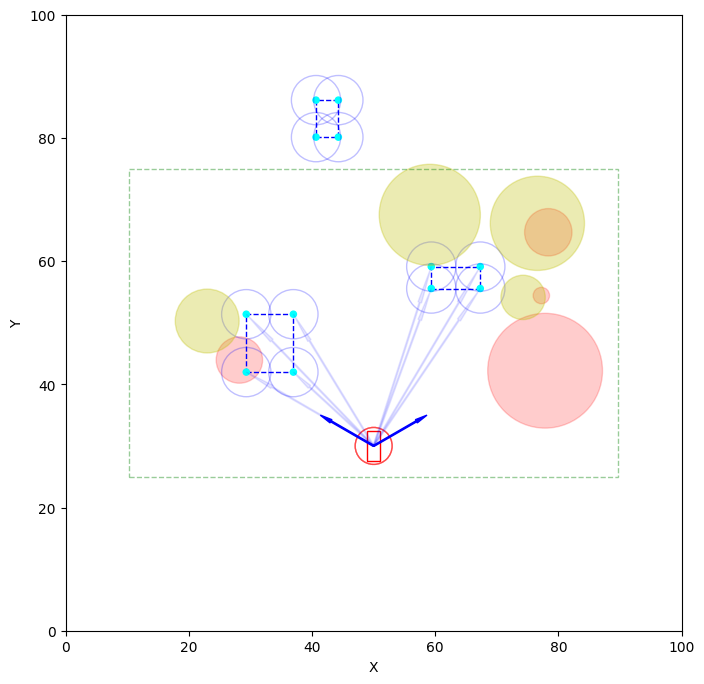

In [103]:
# env = MeasurementControlEnvironment()
object_manager = ObjectManager(object_manager.df, num_obstacles=4, num_occlusion=4, num_oois=3, car_collision_radius=3.0,
                               car_sensor_range=40.0, car_max_bearing=np.radians(60), ui=env.ui)
display(object_manager.df.head())

car_state = np.array([50, 30, 0, np.radians(90), 0, 0])
object_manager.draw_objects(car_state=car_state)
env.car.draw_state(car_state)
df_offending = object_manager.collision_check(car_state=car_state)
observations = object_manager.get_observations(car_state=car_state)
env.ui.plot()
print(f'Observations: {observations}')

In [5]:
a = np.array([[2, 4],
              [5, 6]])
b = np.array([1, 3])

not_in_interval = np.zeros(b.shape, dtype=bool)
for i in range(b.shape[0]):
    # Not any (b < vector of mins) and (b > vector of maxes)
    not_in_interval[i] = ~np.any((a[:,0] < b[i]) & (b[i] < a[:,1]))
    
print(not_in_interval)

[ True False]
